In [1]:
import glia, tables, numpy as np, torch
import torch.nn.functional as F, torchvision
from glia.reconstructions.lib import ImageData, RetinaData, ImageRetina
import matplotlib.pyplot as plt

In [2]:
data_path = "/mnt/fs1/tbenst/200623_faces/R1_E3_AMES_200min_200f_14l_rgb.h5"
# best VAE
model_base = "/mnt/fs1/tbenst/models/3brain/"

In [3]:
hdf5 = tables.open_file(data_path,'r')
h5 = hdf5.root

# crop image
imgs = h5["images"][0:100]
avg_img = np.mean(imgs, axis=(0,3))
y,x = np.where(avg_img>5)
xleft = min(x)
xright = max(x)
ytop = min(y)
ybot = max(y)

image_dset = ImageData(h5["images"], crop=[ytop,ybot,xleft,xright])
retina_dset = RetinaData(h5["data"], no_units=False)
(image_dset[0].shape, retina_dset[0].shape)

nSamples = len(retina_dset)
train_idx = [i for i in range(nSamples) if (i+1)%5 != 0]
val_idx = np.arange(nSamples)[slice(4,nSamples,10)]
test_idx = np.arange(nSamples)[slice(9,nSamples,10)]
dm = ImageRetina(image_dset, retina_dset,batch_size=64,
                 tvt_idxs=(train_idx, val_idx, test_idx))

# VAE

In [ ]:
model_path = model_base+"2020-09-14T04:42:07.773507-optuna/_ckpt_epoch_17.ckpt"

In [19]:
from glia.reconstructions.models.vae import VAE
model = VAE.load_from_checkpoint(model_path)

In [ ]:
for batch in dm.val_dataloader():
    bz = batch[0].shape[0]
    images = batch[0].reshape(bz, -1)
    retina = batch[1].reshape(bz, -1) # flatten
    images_pred, mu, logvar = model(retina)
    mse = F.mse_loss(images.to(device), images_pred, reduction="sum")/bz
    break
print(f"{mse=}")

comparison = torch.cat([images.view(-1,1,model.H,model.W),
               images_pred.view(-1,1,model.H,model.W).cpu()],axis=2).detach()
comparison = torchvision.utils.make_grid(comparison, nrow=12).numpy()
comparison = np.moveaxis(comparison,0,-1)
plt.figure(figsize=(20,20))
plt.imshow(comparison)

In [ ]:
latent = model.latents.view(-1,model.n_latent).to(retina.device)
latent_space = model.decode(latent)
ls = latent_space.view(-1, 1, model.H, model.W)
torchvision.utils.save_image(ls,
           model.save_dir+'/sample_' + str(epoch) + '.png',nrow=model.nrow)

# Conv

In [107]:
ls /mnt/fs1/tbenst/models/3brain/2020-09-14T18:21:53.597586-optuna/trial_126

conv-eigsum_epoch=21_val_mse_loss=47.57.ckpt


In [4]:
# best conv
model_path = model_base+"2020-09-14T18:21:53.597586-optuna/trial_126/conv-eigsum_epoch=21_val_mse_loss=47.57.ckpt"

In [5]:
from glia.reconstructions.models.conv_eigsum import ConvDecoder
model = ConvDecoder.load_from_checkpoint(model_path)
device = 'cuda:9'
model = model.to(device)

mse=tensor(40.7243, device='cuda:9', grad_fn=<DivBackward0>)


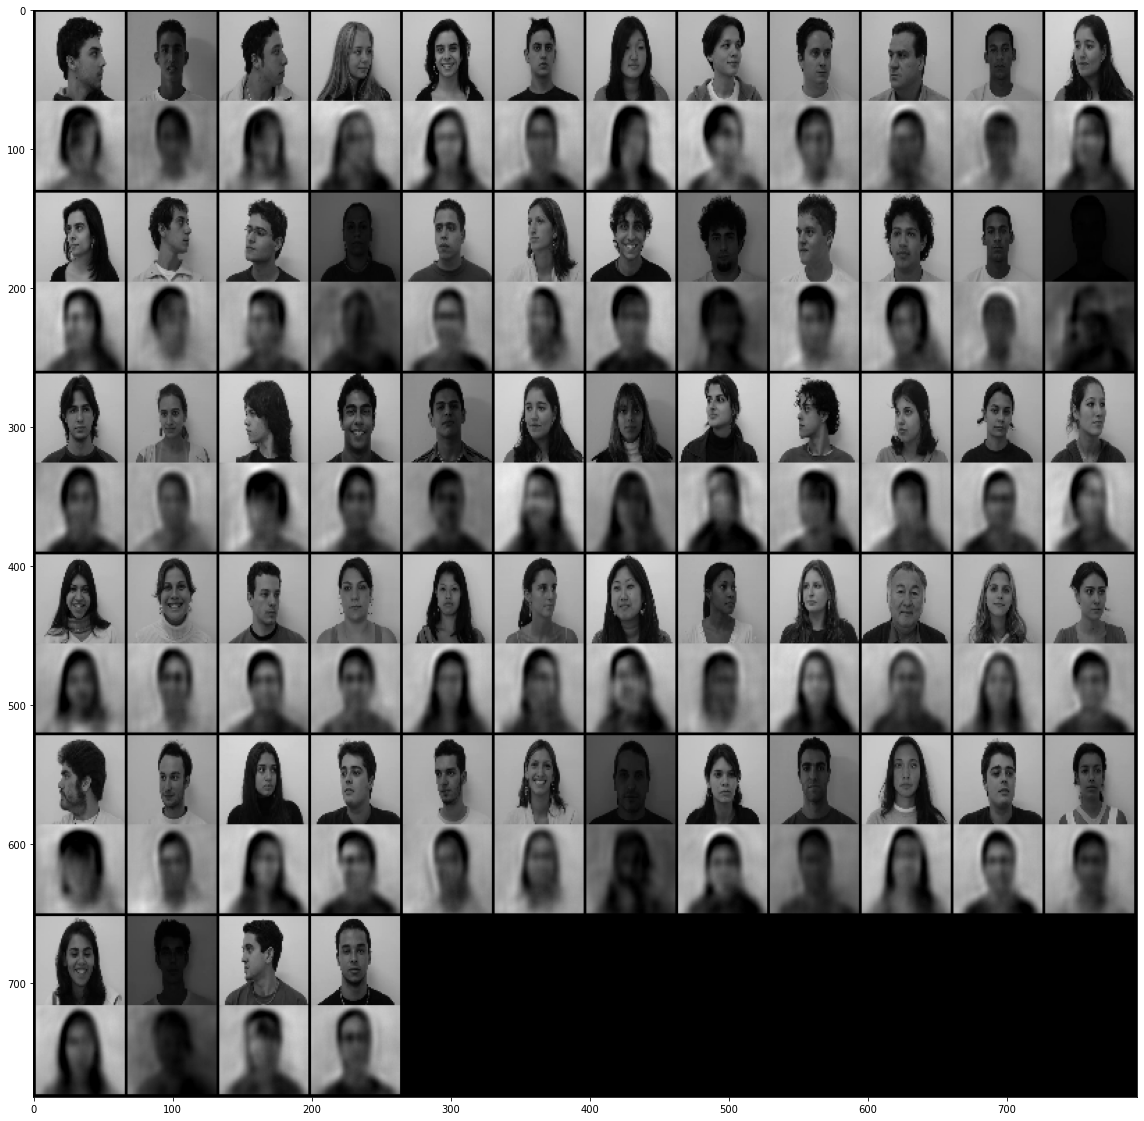

In [9]:
# for batch in dm.train_dataloader():
for batch in dm.val_dataloader():
    bz = batch[0].shape[0]
    images, retina = batch
    images_pred = model(retina.to(device))
    mse = F.mse_loss(images.to(device), images_pred, reduction="sum")/bz
    print(f"{mse=}")
    break

comparison = torch.cat([images.view(-1,1,model.H,model.W),
               images_pred.view(-1,1,model.H,model.W).cpu()],axis=2).detach()
comparison = torchvision.utils.make_grid(comparison, nrow=12).numpy()
comparison = np.moveaxis(comparison,0,-1)
plt.figure(figsize=(20,20))
plt.imshow(comparison)